# Spark session and import ds

In [2]:
##link_dataset: https://www.kaggle.com/datasets/rushikeshdane20/nashik-apartment-price-prediction

from pyspark.sql import SparkSession
from pyspark.sql import functions
spark = SparkSession.builder.appName('pyspark - example join').getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=PySparkShell>

In [3]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression as LinearRegressor
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import StandardScaler
import pandas as pd
import numpy as np
from pyspark.ml.classification import RandomForestClassifier as RF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator as Tester
from pyspark.ml.classification import LogisticRegression as LogisticRegressor
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BinaryEvaluator

In [4]:
dname = "project_biglab.csv"
datapath = os.path.join("/Users/matteofercia/Desktop/datascience/lab_bigdata/project")

In [5]:
df = spark.read.csv(os.path.join(datapath,dname), header=True, inferSchema=True)

# Class definition

In [221]:
class ExpCollector(object):
    
    def __init__(self,data):
        self.data = data
        self.summary = {}
        self.final_data_cluster = self.data.alias('final_data_cluster')
        
    def indexer(self, target):
        final_data = self.data.alias('final_data')
        for col in self.data.dtypes:
            if col[1] == 'string':
                final_data = StringIndexer(inputCol=col[0], outputCol= col[0]+'x').fit(self.data).transform(self.data)
                final_data = final_data.drop(col[0])
        features = [ x for x in final_data.columns ]
        features.remove(target)
        assembler= VectorAssembler(inputCols=features, outputCol="features")
        assembled = assembler.transform(final_data)
        final_data = assembled.select("features",target)
        return final_data
    
    def make_linear_regression(self, target):
        training_set, test_set = self.indexer(target).randomSplit([0.8,0.2], seed=0)
        regressor = LinearRegressor(featuresCol='features', labelCol=target,predictionCol='prediction')
        model = regressor.fit(training_set)
        test_data = test_set.select('features')
        training_data = training_set.select('features')
        predictions_training = model.transform(training_data)
        predictions_test = model.transform(test_data)
        training_result = model.evaluate(training_set)
        test_result = model.evaluate(test_set)
        price_target = test_set.select(target)
        price_points = [ item for item in price_target.collect()]
        performance = model.evaluate(test_set)
        prediction = performance.predictions.select('prediction')
        pred_points = [ item for item in prediction.collect() ]
        results = [('Training set results:',('RMSE:{}'.format(training_result.rootMeanSquaredError)),('MSE:{}'.format(training_result.meanSquaredError)),
                ('R2:{}'.format(model.summary.r2)),'-----------------------------',
               'Test set results:',('RMSE:{}'.format(test_result.rootMeanSquaredError)),
                ('MSE:{}'.format(test_result.meanSquaredError)),
                ('R2:{}'.format(test_result.r2))), plt.scatter(price_points, pred_points)]
        self.summary['linear_regression'] = results
        return results
    
    def remove_string_column(self):
        for col in self.data.dtypes:
            if col[1] == 'string':
                self.final_data_cluster = self.final_data_cluster.drop(col[0])
        return self.final_data_cluster.columns
    
    def make_clustering(self, n_cluster):
        assembler = VectorAssembler(inputCols=self.remove_string_column(), outputCol='features')
        output = assembler.transform(self.final_data_cluster)
        scaler = StandardScaler(inputCol='features',outputCol='scaled', withStd=True,withMean=False)
        model = scaler.fit(output)
        output = model.transform(output)
        kmeans = KMeans(featuresCol='scaled', k=n_cluster)
        model = kmeans.fit(output)
        predictions = model.transform(output)
        tester = ClusteringEvaluator()
        silhouette = tester.evaluate(predictions)
        centers = model.clusterCenters()
        self.summary['kmeans {} clusters'.format(n_cluster)] = silhouette
        return silhouette
    
    def make_clustering2(self, n1, n2):
        assembler = VectorAssembler(inputCols=self.remove_string_column(), outputCol='features')
        output = assembler.transform(self.final_data_cluster)
        scaler = StandardScaler(inputCol='features',outputCol='scaled', withStd=True,withMean=False)
        model = scaler.fit(output)
        output = model.transform(output)
        tester = ClusteringEvaluator()
        summary = []
        for n in range(n1,n2):
            kmeans = KMeans(featuresCol='scaled', k=n)
            model = kmeans.fit(output)
            predictions = model.transform(output)
            silhouette = tester.evaluate(predictions)
            summary += [ silhouette ]
            print(f"Num of clusters: {n} -- Silhouette with euclidean distance: {silhouette}")
        print(summary)
        self.summary['kmeans from {} to {} clusters'.format(n1,n2)] = summary
        return plt.plot(range(n1,n2) ,summary)  
    
    def encoding(self, target):
        indexed = StringIndexer(inputCol=target, outputCol="target").fit(self.data).transform(self.data)
        indexed = indexed.drop(target)
        assembler = VectorAssembler(inputCols = indexed.columns[:-1], outputCol = "features")
        assembled = assembler.transform(indexed)
        selected = assembled.select('features','target')
        return selected
    
    def run_rf(self, target, maxDepth=5, numTrees=20):
        training_set, test_set = self.encoding(target).randomSplit([0.7,0.3], seed=0)
        classifier = RF(maxDepth=5,numTrees=20,labelCol="target")
        model = classifier.fit(training_set)
        print(f"Feature Importance:{model.featureImportances}")
        predictions = model.transform(test_set)
        tester = Tester(predictionCol='prediction', labelCol='target')
        accuracy = tester.evaluate(predictions)
        self.summary['random_forest'] = accuracy
        print(f"Final accuracy is: {accuracy:5.4f}")
        
    def run_reg_log(self, target):
        scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
        model = scaler.fit(self.encoding(target))
        scaled = model.transform(self.encoding(target)).select('scaled_features','target')
        training_set, test_set = scaled.randomSplit([0.7,0.3], seed=0)
        regressor = LogisticRegressor(featuresCol="scaled_features",labelCol='target')
        model = regressor.fit(training_set)
        performance = model.evaluate(test_set)
        predictions = performance.predictions.select('target','prediction')
        evaluator = BinaryEvaluator(rawPredictionCol='prediction', labelCol='target')
        accuracy = evaluator.evaluate(predictions)
        self.summary['logistic_regression'] = accuracy
        print(f"Accuracy: {accuracy}")
        
    def display_summary(self, exp=''):
        if exp in self.summary:
            return self.summary[exp]
        else:
            return self.summary
        

# Linear regression

In [156]:
df2 = df.alias('df2')
df2 = df2.drop('_c0','address','latitude','longitude','owners')
df2 = df2.where("total_sqft<25000")
df2 = df2.where("per_month_emi<300")
df2 = df2.na.drop()
df2 = df2.where("price<150") #cutting oper month emi over 300

In [157]:
analyzer = ExpCollector(indexed)

22/05/01 20:16:46 WARN Instrumentation: [0023868d] regParam is zero, which might cause numerical instability and overfitting.


[('Training set results:',
  'RMSE:6.937765963946868',
  'MSE:48.132596570499615',
  'R2:0.9107088603043545',
  '-----------------------------',
  'Test set results:',
  'RMSE:7.044651043806006',
  'MSE:49.627108328997046',
  'R2:0.9132138990781951'),

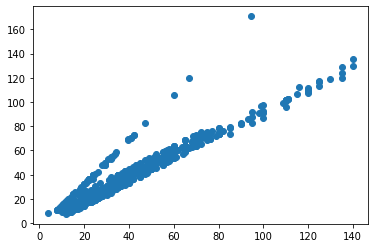

In [158]:
analyzer.make_linear_regression('price')

# Clustering

In [177]:
df3 = df.alias('df3')
df3 = df3.where("total_sqft<25000")
df3 = df3.where("per_month_emi<300")
df3 = df3.drop('_c0','address','latitude','longitude','owners','housetype','house_condition','cordinates')
df3 = df3.where("total_sqft<6000")
df3 = df3.na.drop()

In [222]:
analyzer = ExpCollector(df3)

In [234]:
analyzer.make_clustering(3)

0.43918089828150797

Num of clusters: 3 -- Silhouette with euclidean distance: 0.43918089828150797
Num of clusters: 4 -- Silhouette with euclidean distance: 0.3663491680502436
Num of clusters: 5 -- Silhouette with euclidean distance: 0.3109474630960608
Num of clusters: 6 -- Silhouette with euclidean distance: 0.24228625288615513
Num of clusters: 7 -- Silhouette with euclidean distance: 0.1640489517502853
Num of clusters: 8 -- Silhouette with euclidean distance: 0.08001428273580007
[0.43918089828150797, 0.3663491680502436, 0.3109474630960608, 0.24228625288615513, 0.1640489517502853, 0.08001428273580007]


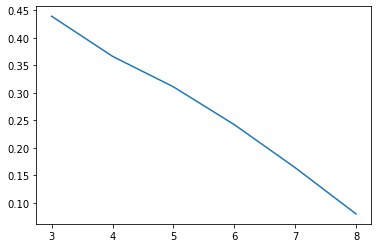

In [235]:
analyzer.make_clustering2(3,9)

In [182]:
analyzer.display_summary()

{'kmeans from 3 to 9 clusters': [0.6252080690780363,
  0.5991722847638973,
  0.36200952170911493,
  0.41320249981892915,
  0.35445302388614497,
  0.2377083367943641],
 'kmeans 3 clusters': 0.6252080690780363}

# Classification

## RF

In [224]:
df4 = df2.alias('df4')
df4 = df4.drop('housetype','cordinates')

In [162]:
df4.printSchema()

root
 |-- house_condition: string (nullable = true)
 |-- BHK: double (nullable = true)
 |-- price: double (nullable = true)
 |-- per_month_emi: double (nullable = true)
 |-- total_sqft: double (nullable = true)



In [233]:
analyzer = ExpCollector(df4)

In [236]:
analyzer.run_rf('house_condition',6,30)

Feature Importance:(4,[0,1,2,3],[0.10399365001805638,0.4975881046621494,0.2510612448370656,0.14735700048272862])
Final accuracy is: 0.6194


## Logistic regression

In [237]:
analyzer.run_reg_log('house_condition')

Accuracy: 0.5960999184582646


22/05/01 21:12:19 WARN Instrumentation: [445d7304] regParam is zero, which might cause numerical instability and overfitting.


[('Training set results:',
  'RMSE:7.256143512348103',
  'MSE:52.651618671791475',
  'R2:0.9023255886239425',
  '-----------------------------',
  'Test set results:',
  'RMSE:7.398595132262446',
  'MSE:54.73920993113756',
  'R2:0.9042740397854734'),

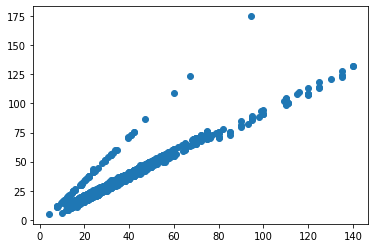

In [238]:
analyzer.make_linear_regression('price')

## Display results

In [239]:
analyzer.display_summary()

{'kmeans 3 clusters': 0.43918089828150797,
 'kmeans from 3 to 9 clusters': [0.43918089828150797,
  0.3663491680502436,
  0.3109474630960608,
  0.24228625288615513,
  0.1640489517502853,
  0.08001428273580007],
 'random_forest': 0.6193706738232356,
 'logistic_regression': 0.5960999184582646,
 'linear_regression': [('Training set results:',
   'RMSE:7.256143512348103',
   'MSE:52.651618671791475',
   'R2:0.9023255886239425',
   '-----------------------------',
   'Test set results:',
   'RMSE:7.398595132262446',
   'MSE:54.73920993113756',
   'R2:0.9042740397854734'),
  <matplotlib.collections.PathCollection at 0x126be3640>]}

In [168]:
analyzer.display_summary('random_forest')

0.6193706738232356

In [240]:
analyzer.display_summary('kmeans 3 clusters')

0.43918089828150797